In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.constants import G
from galpy.potential import NFWPotential, evaluatePotentials, ChandrasekharDynamicalFrictionForce, FDMDynamicalFrictionForce
from galpy.orbit import Orbit
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')
from colossus.halo import concentration
from colossus.halo import profile_nfw

In [ ]:
def find_apocenters(t, r_array):
    """
    Find apocenters in radial distance data.
    Parameters:
    t : array-like
        Time array.
    r_array : array-like
        Radial distance array (shape: [n_orbits, n_timepoints]).
    Returns:
    t_apo : array-like
        Times of apocenters.
    r_apo : array-like
        Radial distances at apocenters.
    """
    dr = np.diff(r_array, axis=1)
    rising = dr[:, :-1] > 0
    falling = dr[:, 1:] < 0
    is_apocentre = rising & falling

    apocentre_indices = np.where(is_apocentre)

    t_apo= t[apocentre_indices[1] + 1]
    r_apo = np.full(r_array.shape[0], np.nan, dtype=float)
    for i_orb in range(r_array.shape[0]):
        indices = apocentre_indices[1][apocentre_indices[0] == i_orb]
        
        r_apo[i_orb] = r_array[i_orb, indices + 1][-1] if r_array[i_orb, indices + 1].size > 0 else np.nan
    
    return t_apo, r_apo

## Parameters and initialization

In [ ]:
G = G.to(u.kpc/u.Msun*(u.km/u.s)**2).value# Gravitational constant in kpc3/(Msun s2)
h = 0.704 # Hubble constant


redshift = 0 #redshift
Mobj = 1e6 #mass of the satellite
rhm = 0.01 #half mass radius of the satellite
N = 1000 #number of particles
t0 = 0 #initial time
tf = 10 #final time
Nsteps = 1000 #number of steps
seed = 42 #seed for random number generation


M_grid = np.logspace(9, 11, 16) #halo mass grid
m_grid = np.logspace(-1, 2, 16) #FDM mass grid
efficiencyFDMonlyDF = np.zeros((len(M_grid), len(m_grid))) #efficiency grid for FDM (only DF)
efficiencyCDM = np.zeros(len(M_grid)) #efficiency grid for CDM

## Computation of the efficiency

In [ ]:
for i, Mi in enumerate(M_grid):
    print("\rComputing for M = %.1E\r"%Mi)

    # Halo profile
    c = concentration.concentration(Mi,'vir',redshift,model ='prada12')
    p_nfw= profile_nfw.NFWProfile(M = Mi, c = c, z = redshift, mdef = 'vir')

    r_vir = p_nfw.RDelta(redshift, 'vir')/h #virial radius 
    r_s = p_nfw.par['rs']/h #scale radius

    A_NFW = np.log(1 + c) - c/(1+c)

    NFWHalo = NFWPotential(amp = Mi/A_NFW* u.Msun, a = r_s * u.kpc)

    # Initial conditions

    np.random.seed(seed)
    # Compute a random R grid 
    R = np.exp(np.random.uniform(np.log(1e-1 * r_s), np.log(10 * r_s), N))
    # For each R, compute the escape velocity
    POT = evaluatePotentials(NFWHalo, R * u.kpc, 0.)
    vEsc = f.vesc(POT)
    # Compute a random vT for each R, lower that the escape velocity
    vT = np.array([np.random.uniform(-v,v) for v in vEsc])
    # Compute the radial velocity for each R, with condition v² < vesc² - vT²
    vR = np.array([np.random.uniform(-v, v) for v in np.sqrt(vEsc**2 - vT**2)])

    initial = [[R[i] * u.kpc, vR[i] * u.km/u.s, vT[i] * u.km/u.s, 0. * u.kpc, 0. * u.km/u.s, 0.* u.rad] for i in range(N)]
    o = Orbit(initial)
    o_CDM = o()
    o_FDM = o()

    # Integration
    t = np.linspace(t0, tf, Nsteps) * u.Gyr
    #no DF case
    o.integrate(t, NFWHalo, method = 'dop853_c') 

    # CDM case
    cdf = ChandrasekharDynamicalFrictionForce(GMs=Mobj * u.Msun,rhm = rhm * u.kpc, dens=NFWHalo)
    o_CDM.integrate(t, NFWHalo + cdf, method = 'dop853_c')
    t_apo, r_apo = find_apocenters(t, o.R(t)) #no DF apocenters
    t_apo, r_apo_CDM = find_apocenters(t, o_CDM.R(t)) #CDM apocenters
    final_rapo_ratio = (r_apo- r_apo_CDM)/r_apo 
    final_rapo_ratio = final_rapo_ratio[final_rapo_ratio >= 0] #filter out negative values due to numerical instabilities
    efficiencyCDM[i] = np.mean(final_rapo_ratio[np.isnan(final_rapo_ratio)!=True])

    # FDM case
    for j, mj in enumerate(m_grid):
        fdf  = FDMDynamicalFrictionForce(GMs=Mobj * u.Msun,rhm = rhm * u.kpc, dens=NFWHalo, m = mj * 1e-22 * u.eV)
        o_FDM.integrate(t, NFWHalo + fdf, method = 'dop853_c')
        t_apo, r_apo_FDM = find_apocenters(t, o_FDM.R(t))
        final_rapo_ratio = (r_apo- r_apo_FDM)/r_apo
        final_rapo_ratio = final_rapo_ratio[final_rapo_ratio >= 0] #filter out negative values due to numerical instabilities
        efficiencyFDMonlyDF[i][j] = np.mean(final_rapo_ratio[np.isnan(final_rapo_ratio)!=True])
    
efficiencyCDM = np.tile(efficiencyCDM, (len(m_grid), 1)).T

Computing for M = 1.0E+09


Computing for m = 1.0E-01


Computing for m = 1.6E-01


Computing for m = 2.5E-01


Computing for m = 4.0E-01


Computing for m = 6.3E-01


Computing for m = 1.0E+00


Computing for m = 1.6E+00


Computing for m = 2.5E+00


Computing for m = 4.0E+00


Computing for m = 6.3E+00


Computing for m = 1.0E+01


Computing for m = 1.6E+01


Computing for m = 2.5E+01


Computing for m = 4.0E+01


Computing for m = 6.3E+01


Computing for m = 1.0E+02


Computing for M = 1.4E+09


Computing for m = 1.0E-01


Computing for m = 1.6E-01


Computing for m = 2.5E-01


Computing for m = 4.0E-01


Computing for m = 6.3E-01


Computing for m = 1.0E+00


Computing for m = 1.6E+00


Computing for m = 2.5E+00


Computing for m = 4.0E+00


Computing for m = 6.3E+00


Computing for m = 1.0E+01


Computing for m = 1.6E+01


Computing for m = 2.5E+01


Computing for m = 4.0E+01


Computing for m = 6.3E+01


Computing for m = 1.0E+02


Computing for M = 1.8E+09


Computing for m = 1.0E-01


Computing for m = 1.6E-01


Computing for m = 2.5E-01


Computing for m = 4.0E-01


Computing for m = 6.3E-01


Computing for m = 1.0E+00


Computing for m = 1.6E+00


Computing for m = 2.5E+00


Computing for m = 4.0E+00


Computing for m = 6.3E+00


Computing for m = 1.0E+01


Computing for m = 1.6E+01


Computing for m = 2.5E+01


Computing for m = 4.0E+01


Computing for m = 6.3E+01


Computing for m = 1.0E+02


Computing for M = 2.5E+09


Computing for m = 1.0E-01


Computing for m = 1.6E-01


Computing for m = 2.5E-01


Computing for m = 4.0E-01


Computing for m = 6.3E-01


Computing for m = 1.0E+00


Computing for m = 1.6E+00


Computing for m = 2.5E+00


Computing for m = 4.0E+00


Computing for m = 6.3E+00


Computing for m = 1.0E+01


Computing for m = 1.6E+01


Computing for m = 2.5E+01


Computing for m = 4.0E+01


Computing for m = 6.3E+01


Computing for m = 1.0E+02


Computing for M = 3.4E+09


Computing for m = 1.0E-01


Computing for m = 1.6E-01


Computing for m = 2.5E-01


Computing for m = 4.0E-01


Computing for m = 6.3E-01


Computing for m = 1.0E+00


Computing for m = 1.6E+00


Computing for m = 2.5E+00


Computing for m = 4.0E+00


Computing for m = 6.3E+00


Computing for m = 1.0E+01


Computing for m = 1.6E+01


Computing for m = 2.5E+01


Computing for m = 4.0E+01


Computing for m = 6.3E+01


Computing for m = 1.0E+02


Computing for M = 4.6E+09


Computing for m = 1.0E-01


Computing for m = 1.6E-01


Computing for m = 2.5E-01


Computing for m = 4.0E-01


Computing for m = 6.3E-01


Computing for m = 1.0E+00


Computing for m = 1.6E+00


Computing for m = 2.5E+00


Computing for m = 4.0E+00


Computing for m = 6.3E+00


Computing for m = 1.0E+01


Computing for m = 1.6E+01


Computing for m = 2.5E+01


Computing for m = 4.0E+01


Computing for m = 6.3E+01


Computing for m = 1.0E+02


Computing for M = 6.3E+09


Computing for m = 1.0E-01


Computing for m = 1.6E-01


Computing for m = 2.5E-01


Computing for m = 4.0E-01


Computing for m = 6.3E-01


Computing for m = 1.0E+00


Computing for m = 1.6E+00


Computing for m = 2.5E+00


Computing for m = 4.0E+00


Computing for m = 6.3E+00


Computing for m = 1.0E+01


Computing for m = 1.6E+01


Computing for m = 2.5E+01


Computing for m = 4.0E+01


Computing for m = 6.3E+01


Computing for m = 1.0E+02


Computing for M = 8.6E+09


Computing for m = 1.0E-01


Computing for m = 1.6E-01


Computing for m = 2.5E-01


Computing for m = 4.0E-01


Computing for m = 6.3E-01


Computing for m = 1.0E+00


Computing for m = 1.6E+00


Computing for m = 2.5E+00


Computing for m = 4.0E+00


Computing for m = 6.3E+00


Computing for m = 1.0E+01


Computing for m = 1.6E+01


Computing for m = 2.5E+01


Computing for m = 4.0E+01


Computing for m = 6.3E+01


Computing for m = 1.0E+02


Computing for M = 1.2E+10


Computing for m = 1.0E-01


Computing for m = 1.6E-01


Computing for m = 2.5E-01


Computing for m = 4.0E-01


Computing for m = 6.3E-01


Computing for m = 1.0E+00


Computing for m = 1.6E+00


Computing for m = 2.5E+00


Computing for m = 4.0E+00


Computing for m = 6.3E+00


Computing for m = 1.0E+01


Computing for m = 1.6E+01


Computing for m = 2.5E+01


Computing for m = 4.0E+01


Computing for m = 6.3E+01


Computing for m = 1.0E+02


Computing for M = 1.6E+10


Computing for m = 1.0E-01


Computing for m = 1.6E-01


Computing for m = 2.5E-01


Computing for m = 4.0E-01


Computing for m = 6.3E-01


Computing for m = 1.0E+00


Computing for m = 1.6E+00


Computing for m = 2.5E+00


Computing for m = 4.0E+00


Computing for m = 6.3E+00


Computing for m = 1.0E+01


Computing for m = 1.6E+01


Computing for m = 2.5E+01


Computing for m = 4.0E+01


Computing for m = 6.3E+01


Computing for m = 1.0E+02


Computing for M = 2.2E+10


Computing for m = 1.0E-01


Computing for m = 1.6E-01


Computing for m = 2.5E-01


Computing for m = 4.0E-01


Computing for m = 6.3E-01


Computing for m = 1.0E+00


Computing for m = 1.6E+00


Computing for m = 2.5E+00


Computing for m = 4.0E+00


Computing for m = 6.3E+00


Computing for m = 1.0E+01


Computing for m = 1.6E+01


Computing for m = 2.5E+01


Computing for m = 4.0E+01


Computing for m = 6.3E+01


Computing for m = 1.0E+02


Computing for M = 2.9E+10


Computing for m = 1.0E-01


Computing for m = 1.6E-01


Computing for m = 2.5E-01


Computing for m = 4.0E-01


Computing for m = 6.3E-01


Computing for m = 1.0E+00


Computing for m = 1.6E+00


Computing for m = 2.5E+00


Computing for m = 4.0E+00


Computing for m = 6.3E+00


Computing for m = 1.0E+01


Computing for m = 1.6E+01


Computing for m = 2.5E+01


Computing for m = 4.0E+01


Computing for m = 6.3E+01


Computing for m = 1.0E+02


Computing for M = 4.0E+10


Computing for m = 1.0E-01


Computing for m = 1.6E-01


Computing for m = 2.5E-01


Computing for m = 4.0E-01


Computing for m = 6.3E-01


Computing for m = 1.0E+00


Computing for m = 1.6E+00


Computing for m = 2.5E+00


Computing for m = 4.0E+00


Computing for m = 6.3E+00


Computing for m = 1.0E+01


Computing for m = 1.6E+01


Computing for m = 2.5E+01


Computing for m = 4.0E+01


Computing for m = 6.3E+01


Computing for m = 1.0E+02


Computing for M = 5.4E+10


Computing for m = 1.0E-01


Computing for m = 1.6E-01


Computing for m = 2.5E-01


Computing for m = 4.0E-01


Computing for m = 6.3E-01


Computing for m = 1.0E+00


Computing for m = 1.6E+00


Computing for m = 2.5E+00


Computing for m = 4.0E+00


Computing for m = 6.3E+00


Computing for m = 1.0E+01


Computing for m = 1.6E+01


Computing for m = 2.5E+01


Computing for m = 4.0E+01


Computing for m = 6.3E+01


Computing for m = 1.0E+02


Computing for M = 7.4E+10


Computing for m = 1.0E-01


Computing for m = 1.6E-01


Computing for m = 2.5E-01


Computing for m = 4.0E-01


Computing for m = 6.3E-01


Computing for m = 1.0E+00


Computing for m = 1.6E+00


Computing for m = 2.5E+00


Computing for m = 4.0E+00


Computing for m = 6.3E+00


Computing for m = 1.0E+01


Computing for m = 1.6E+01


Computing for m = 2.5E+01


Computing for m = 4.0E+01


Computing for m = 6.3E+01


Computing for m = 1.0E+02


Computing for M = 1.0E+11


Computing for m = 1.0E-01


Computing for m = 1.6E-01


Computing for m = 2.5E-01


Computing for m = 4.0E-01


Computing for m = 6.3E-01


Computing for m = 1.0E+00


Computing for m = 1.6E+00


Computing for m = 2.5E+00


Computing for m = 4.0E+00


Computing for m = 6.3E+00


Computing for m = 1.0E+01


Computing for m = 1.6E+01


Computing for m = 2.5E+01


Computing for m = 4.0E+01


Computing for m = 6.3E+01


Computing for m = 1.0E+02


In [104]:
meshm ,meshMratio = np.meshgrid(m_grid, M_grid/Mobj)

## Plots

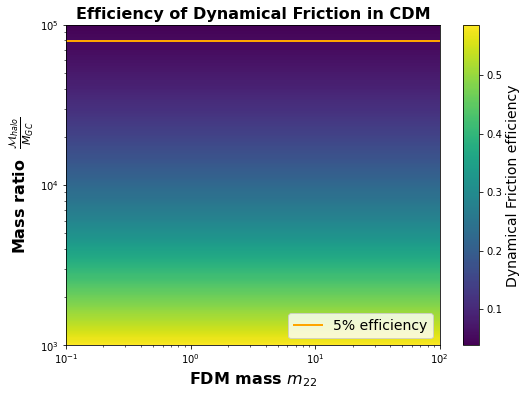

In [118]:
plt.figure(figsize=(8,6))
plt.contourf(meshm, meshMratio, efficiencyCDM, levels=300, cmap='viridis')
cbar=plt.colorbar(ticks=np.arange(0.0,np.max(efficiencyCDM), 0.1))
cbar.set_label('Dynamical Friction efficiency', fontsize=14)
cdm_line = plt.contour(meshm, meshMratio, efficiencyCDM, levels=[0.05], colors='orange', linewidths=2)



from matplotlib.lines import Line2D
cdm_legend_line = Line2D([0], [0], color='orange', linewidth=2, label='5% efficiency')
plt.legend(handles=[cdm_legend_line], loc='lower right', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'FDM mass $m_{22}$', fontsize=16, fontweight='bold')
plt.ylabel(r'Mass ratio  $\frac{{\mathcal{{M}}_{{halo}}}}{{M_{{GC}}}}$', fontsize=16, fontweight='bold')
plt.title('Efficiency of Dynamical Friction in CDM', fontsize=16, fontweight='bold')
plt.tight_layout(pad=2.5)
plt.show()

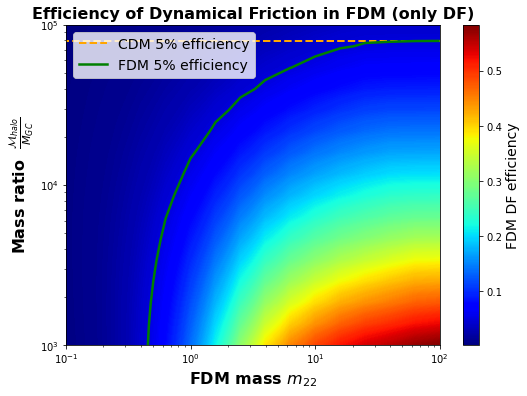

In [110]:
plt.figure(figsize=(8,6))
plt.contourf(meshm, meshMratio, efficiencyFDMonlyDF, levels=300, cmap='jet')#, vmin=0.05, vmax=max(efficiency))
cbar=plt.colorbar(ticks=np.arange(0.0,np.max(efficiencyFDMonlyDF), 0.1))
cbar.set_label('FDM DF efficiency', fontsize=14)
cdm_line = plt.contour(meshm, meshMratio, efficiencyCDM, levels=[0.05], colors='orange', linewidths=2, linestyles='dashed')
contour_line = plt.contour(meshm, meshMratio, efficiencyFDMonlyDF, levels=[0.05], colors='green', linewidths=2.5)

from matplotlib.lines import Line2D
legend_line = Line2D([0], [0], color='green', linewidth=2.5, label='FDM 5% efficiency')
cdm_legend_line = Line2D([0], [0], color='orange',linestyle='--', linewidth=2, label='CDM 5% efficiency')
plt.legend(handles=[cdm_legend_line,legend_line], loc='upper left', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'FDM mass $m_{22}$', fontsize=16, fontweight='bold')
plt.ylabel(r'Mass ratio  $\frac{{\mathcal{{M}}_{{halo}}}}{{M_{{GC}}}}$', fontsize=16, fontweight='bold')
plt.title('Efficiency of Dynamical Friction in FDM (only DF)', fontsize=16, fontweight='bold')
plt.tight_layout(pad=2.5)
plt.show()